# Лабораторная работа №4
## Решение краевой задачи методом прогонки
# Вариант №11
## В работе численно решается уравнение Теплопроводности:
$$
\frac{d}{dx} [k(x) \frac{du}{dx}] -q(x) u = -f(x)  \\
q(x) = x^2 \\
f(x) = cos (x)
$$

при этом функция k(x) испытывает разрыв в точке $x_0 = 0.125$:

$$
x < x_0: k(x) = x + 1 \\
x > x_0: k(x) = x^2
$$

условия на решение в точке разрыва:

$$
\begin{cases}
  u(x_0 - 0) = u(x_0 + 0) \\
  k(x_0 - 0) * \frac{du}{dx}(x_0 - 0) = k(x_0 + 0) \frac{du}{dx}(x_0 + 0)
\end{cases}
$$



In [50]:
import numpy as np
import math as mh
import matplotlib.pyplot as plt

In [51]:
def k_a(x):
  return x + 1

def k_b(x):
  return x*x

def q(x):
  return x*x

def fnc(x):
  return np.cos(x)

In [52]:
def straight(A, f, alpha, k_alpha, k_beta):
    size = np.size(f)
    B = np.zeros((size, size))
    f_B = np.zeros(size)
    u_0 = f[0]
    u_L = f[-1]
    
    B[0][0] = 1
    f_B[0] = u_0

    B[-1][-1] = 1
    f_B[-1] = u_L
    
    B[1][1] = 1
    B[1][2] = A[1][2] / A[1][1]
    f_B[1] = (f[1] - A[1][0] * u_0) / A[1][1]
    for l in range(2, alpha):
        a = A[l][l + 1] /                                 \
            (A[l][l] - A[l][l - 1] * B[l - 1][(l - 1) + 1])
        b = (f[l] - A[l][l - 1] * f_B[l - 1]) /             \
            (A[l][l] - A[l][l - 1] * B[l - 1][(l - 1) + 1])
        B[l][l] = 1
        B[l][l + 1] = a
        f_B[l] = b

    B[size - 2][size - 2] = 1
    B[size - 2][size - 3] = A[size - 2][size - 3] / \
                            A[size - 2][size - 2]
    f_B[size - 2] = (f[size - 2] - A[size - 2][size - 3] * u_L) / \
                    A[size - 2][size - 2]
    for l in reversed(range(alpha + 2, size - 1)):
        a = A[l][l - 1] / \
            (A[l][l] - A[l][l + 1] * B[l + 1][(l + 1) - 1])
        b = (f[l] - A[l][l + 1] * f_B[l + 1]) / \
            (A[l][l] - A[l][l + 1] * B[l + 1][(l + 1) - 1])
        B[l][l] = 1
        B[l][l - 1] = a
        f_B[l] = b
    beta = alpha + 1
    u_alpha = (k_alpha * f_B[alpha - 1] + k_beta * f_B[beta + 1]) / \
                (k_alpha * (1 + B[alpha - 1][(alpha - 1) + 1]) + \
                k_beta * (1 + B[beta + 1][(beta + 1) - 1]))
    B[alpha][alpha] = 1
    B[beta][beta] = 1
    f_B[alpha] = u_alpha
    f_B[beta] = u_alpha
    return B, f_B

def back(A, f, alpha):
    size = np.size(f)
    u = np.zeros(size)
    u[0] = f[0]
    u[-1] = f[-1]
    u[alpha] = f[alpha]
    u[alpha + 1] = f[alpha + 1]
    for l in reversed(range(1, alpha)):
        a = A[l][l + 1]
        u[l] = -a * u[l + 1] + f[l]
    for l in range(alpha + 2, size - 1): 
        a = A[l][l - 1]
        u[l] = -a * u[l - 1] + f[l]
    return u

def solve(A, f, alpha, k_alpha, k_beta):
    B, f_B = straight(A, f, alpha, k_alpha, k_beta)
    return back(B, f_B, alpha)

In [53]:
def calc_coefs(h, x_0, x_L, alpha):
    size = mh.ceil((x_L - x_0) / h) + 1
    A = np.zeros((size, size))
    for l in range(1, alpha):
        x_l = x_0 + l * h
        a = k_a(x_l + 1/2 * h)
        b = -(k_a(x_l + 1/2 * h) + k_a(x_l - 1/2 * h) + q(x_l) * h*h)
        c = k_a(x_l - 1/2 * h)
        A[l][l - 1] = c
        A[l][l] = b
        A[l][l + 1] = a 
    A[alpha][alpha] = 1
    A[alpha][alpha + 1] = -1
    A[alpha + 1][alpha] = k_a(x_0 + alpha * h)
    A[alpha + 1][alpha - 1] = -k_a(x_0 + alpha * h)
    beta = alpha + 1
    A[alpha + 1][beta + 1] = -k_b(x_0 + beta * h)
    A[alpha + 1][beta] = k_b(x_0 + beta * h)
    for l in range(alpha + 2, size - 1):
        x_l = x_0 + l * h
        a = k_b(x_l + 1/2 * h)
        b = -(k_b(x_l + 1/2 * h) + k_b(x_l - 1/2 * h) + q(x_l) * h*h)
        c = k_b(x_l - 1/2 * h)
        A[l][l - 1] = c
        A[l][l] = b
        A[l][l + 1] = a
    A[0][0] = 1 
    A[-1][-1] = 1
    return A
  
def calc_heterogeneity(h, x_0, x_L, u_0, u_L, alpha):
    size = mh.ceil((x_L - x_0) / h) + 1
    f = np.zeros(size)
    for l in range(1, size):
        x_l = x_0 + l * h
        f[l] = -(fnc(x_l)) * h*h
    f[alpha] = 0
    f[alpha + 1] = 0
    f[0] = u_0
    f[-1] = u_L
    return f 

def draw(u, x, ax):
    ax.plot(x, u, "r")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('DE solvation')
    ax.grid()  

def solve_linalg(A, f):
    return np.linalg.solve(A, f)

def solve_real(h, x_0, x_L):
    pass

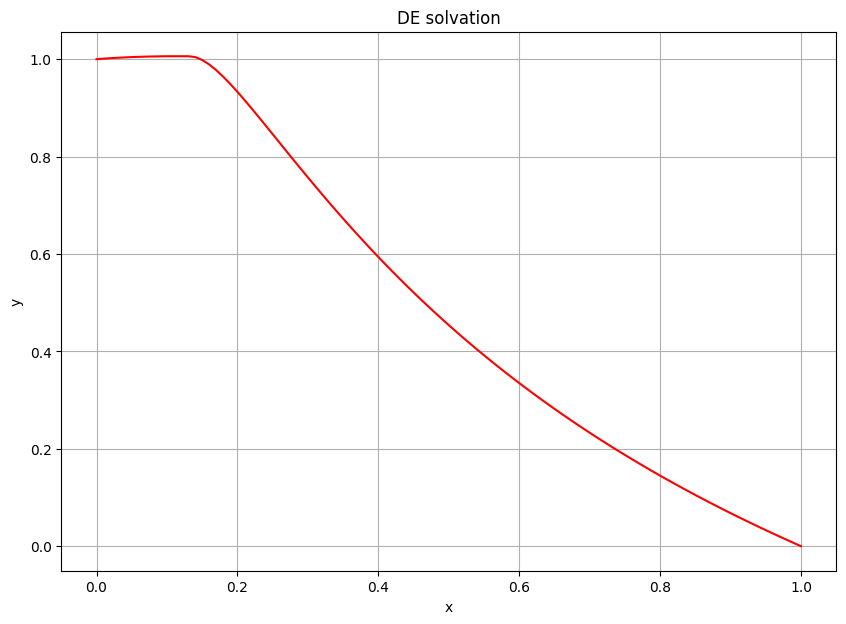

In [54]:
u_0 = 1
u_L = 0
x_0 = 0
x_L = 1
x_singul = 0.125
h = 0.01
alpha = int(x_singul / h)
k_alpha = k_a(x_0 + alpha * h)
k_beta = k_b(x_0 + (alpha + 1) * h)
A = calc_coefs(h, x_0, x_L, alpha)
f = calc_heterogeneity(h, x_0, x_L, u_0, u_L, alpha)
u = solve(A, f, alpha, k_alpha, k_beta)
x = np.linspace(x_0, x_L, mh.ceil((x_L - x_0) / h) + 1)
fig, ax = plt.subplots(figsize=(10, 7))
draw(u, x, ax)
plt.show()